# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11945634965877845607
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [5]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.677s 


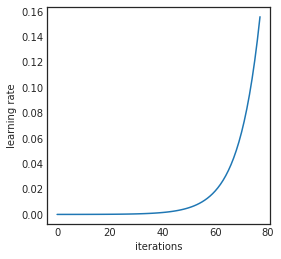

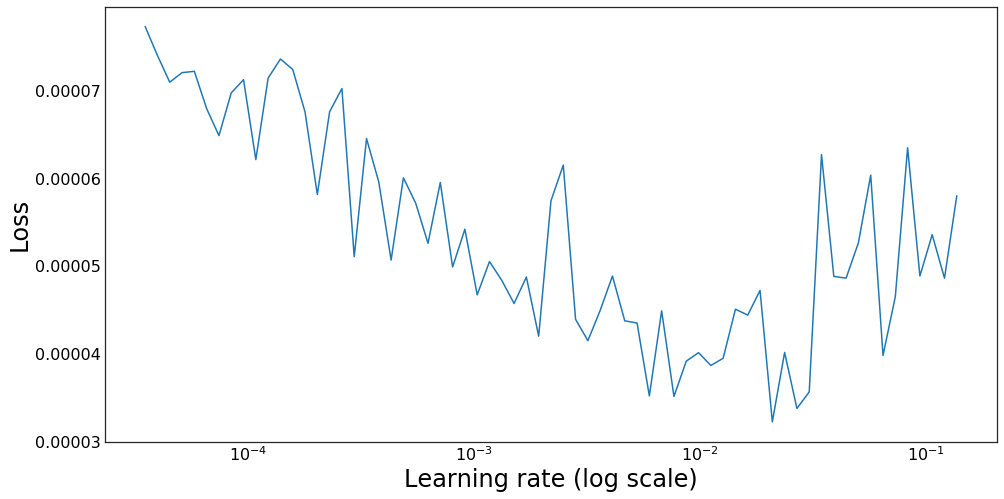

______________________________________



In [6]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [7]:
compileArgs['lr'] = 1e-3

In [12]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1, sgdReplacement=False,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights, sgdReplacement=sgdReplacement)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [13]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            if self.sgdReplacement:
                print("Starting SGD from old average")
                self.model.set_weights(self.swa_model)
                self.n_since_renewal = 0
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.swa_n = self.n_since_renewal
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

SWA beginning
model is 0 epochs old
1 swa loss 4.150693280720339e-05, default loss 4.150693280720339e-05
1 New best found: 4.150693280720339e-05
model is 1 epochs old
2 swa loss 3.977289844470714e-05, default loss 3.874509394111976e-05
2 New best found: 3.874509394111976e-05
model is 2 epochs old
3 swa loss 3.870535248408426e-05, default loss 3.7473703349197954e-05
3 New best found: 3.7473703349197954e-05
model is 3 epochs old
4 swa loss 3.8006330126181506e-05, default loss 3.6697243328524245e-05
4 New best found: 3.6697243328524245e-05
model is 4 epochs old
5 swa loss 3.7472606155679784e-05, default loss 3.634889513448992e-05
5 New best found: 3.634889513448992e-05
model is 5 epochs old
6 swa loss 3.707962548442657e-05, default loss 3.590549198347904e-05
6 New best found: 3.590549198347904e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.6742152231972404e-05, defa

model is 1 epochs old
55 swa loss 3.38901568511335e-05, default loss 3.393436883017739e-05
model is 2 epochs old
56 swa loss 3.373121943318502e-05, default loss 3.370694892042707e-05
model is 3 epochs old
57 swa loss 3.365363116109718e-05, default loss 3.376311966746178e-05
model is 4 epochs old
58 swa loss 3.3561529619825575e-05, default loss 3.3661636109636104e-05
model is 5 epochs old
59 swa loss 3.354494691929217e-05, default loss 3.3718864281793084e-05
model is 6 epochs old
new model is 1 epochs old
60 swa loss 3.352052322161165e-05, default loss 3.3868689534689975e-05
model is 7 epochs old
new model is 2 epochs old
61 swa loss 3.351996972649081e-05, default loss 3.3973365143082926e-05
model is 8 epochs old
new model is 3 epochs old
62 swa loss 3.346347762468421e-05, default loss 3.3538382262860305e-05
model is 9 epochs old
new model is 4 epochs old
63 swa loss 3.3458996891857336e-05, default loss 3.37884480327604e-05
model is 10 epochs old
new model is 5 epochs old
Checking renew

113 swa loss 3.3039042553197856e-05, default loss 3.322534790762068e-05
model is 6 epochs old
new model is 1 epochs old
114 swa loss 3.30567536008875e-05, default loss 3.352623813702088e-05
model is 7 epochs old
new model is 2 epochs old
115 swa loss 3.303996899780512e-05, default loss 3.331760121586983e-05
model is 8 epochs old
new model is 3 epochs old
116 swa loss 3.300605500643239e-05, default loss 3.3132180584320576e-05
model is 9 epochs old
new model is 4 epochs old
117 swa loss 3.3012011061122485e-05, default loss 3.347852693961382e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.299290911703754e-05, new model: 3.3006310721933516e-05
Current model better, renewing
____________________


118 swa loss 3.299290911703754e-05, default loss 3.319429781190956e-05
model is 11 epochs old
new model is 1 epochs old
119 swa loss 3.296634351804535e-05, default loss 3.3033759928564425e-05
model is 12 epochs old
new model is 2 epochs old
120 swa

170 swa loss 3.275557744014941e-05, default loss 3.276366165603307e-05
170 New best found: 3.275557744014941e-05
SWA beginning
model is 0 epochs old
171 swa loss 3.302101999859362e-05, default loss 3.302101999859362e-05
model is 1 epochs old
172 swa loss 3.2889586387629334e-05, default loss 3.302255470176199e-05
model is 2 epochs old
173 swa loss 3.2845716074314334e-05, default loss 3.301360964632381e-05
model is 3 epochs old
174 swa loss 3.279651514973204e-05, default loss 3.3005342296194915e-05
model is 4 epochs old
175 swa loss 3.27641936572763e-05, default loss 3.293438711902622e-05
model is 5 epochs old
176 swa loss 3.275772171657869e-05, default loss 3.2992512277797736e-05
model is 6 epochs old
new model is 1 epochs old
177 swa loss 3.275216544019548e-05, default loss 3.310834321615209e-05
177 New best found: 3.275216544019548e-05
model is 7 epochs old
new model is 2 epochs old
178 swa loss 3.2747252122886184e-05, default loss 3.311811143964324e-05
178 New best found: 3.274725212

model is 19 epochs old
new model is 9 epochs old
226 swa loss 3.2579039830597345e-05, default loss 3.277543784513381e-05
226 New best found: 3.2579039830597345e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.257333110292152e-05, new model: 3.2579980076937895e-05
Current model better, renewing
____________________


227 swa loss 3.257333110292152e-05, default loss 3.273580339039325e-05
227 New best found: 3.257333110292152e-05
model is 21 epochs old
new model is 1 epochs old
228 swa loss 3.256946970465602e-05, default loss 3.277248505287904e-05
228 New best found: 3.256946970465602e-05
model is 22 epochs old
new model is 2 epochs old
229 swa loss 3.256616892959254e-05, default loss 3.278263212663604e-05
229 New best found: 3.256616892959254e-05
model is 23 epochs old
new model is 3 epochs old
230 swa loss 3.256206904268143e-05, default loss 3.28062068149913e-05
230 New best found: 3.256206904268143e-05
model is 24 epochs old
new model i

model is 71 epochs old
new model is 16 epochs old
278 swa loss 3.249415935078828e-05, default loss 3.2688173795250865e-05
278 New best found: 3.249415935078828e-05
model is 72 epochs old
new model is 17 epochs old
279 swa loss 3.24935999873326e-05, default loss 3.277853930180282e-05
279 New best found: 3.24935999873326e-05
model is 73 epochs old
new model is 18 epochs old
280 swa loss 3.24930877963491e-05, default loss 3.297682355205586e-05
280 New best found: 3.24930877963491e-05
model is 74 epochs old
new model is 19 epochs old
281 swa loss 3.249038600294165e-05, default loss 3.269828996744638e-05
281 New best found: 3.249038600294165e-05
model is 75 epochs old
new model is 20 epochs old
282 swa loss 3.2487851793720955e-05, default loss 3.273752231948698e-05
282 New best found: 3.2487851793720955e-05
model is 76 epochs old
new model is 21 epochs old
283 swa loss 3.2483569210759975e-05, default loss 3.25848345589981e-05
283 New best found: 3.2483569210759975e-05
model is 77 epochs old

Score is: {'loss': 3.2428456443338735e-05, 'wAUC': 0.06661573177979752, 'AUC': 0.1020740970876961}
Fold took 461.245s

Running fold 2 / 10
SWA beginning
model is 0 epochs old
1 swa loss 4.14368194945904e-05, default loss 4.14368194945904e-05
1 New best found: 4.14368194945904e-05
model is 1 epochs old
2 swa loss 3.928478555142153e-05, default loss 3.782644421011144e-05
2 New best found: 3.782644421011144e-05
model is 2 epochs old
3 swa loss 3.804416500998752e-05, default loss 3.6449851103174357e-05
3 New best found: 3.6449851103174357e-05
model is 3 epochs old
4 swa loss 3.714326094635435e-05, default loss 3.551826576721353e-05
4 New best found: 3.551826576721353e-05
model is 4 epochs old
5 swa loss 3.6633309864639156e-05, default loss 3.528018041212849e-05
5 New best found: 3.528018041212849e-05
model is 5 epochs old
6 swa loss 3.6205383024224686e-05, default loss 3.48525749165047e-05
6 New best found: 3.48525749165047e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.5

model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2463171273489495e-05, new model: 3.244380443883393e-05
New model better, replacing
____________________


Starting SGD from old average
54 swa loss 3.244380443883393e-05, default loss 3.2463171273489495e-05
54 New best found: 3.244380443883393e-05
SWA beginning
model is 0 epochs old
55 swa loss 3.278838508364718e-05, default loss 3.278838508364718e-05
model is 1 epochs old
56 swa loss 3.24849097312846e-05, default loss 3.269664943062533e-05
model is 2 epochs old
57 swa loss 3.244309766945986e-05, default loss 3.262875292979306e-05
57 New best found: 3.244309766945986e-05
model is 3 epochs old
58 swa loss 3.2419970667127895e-05, default loss 3.267145954606952e-05
58 New best found: 3.2419970667127895e-05
model is 4 epochs old
59 swa loss 3.242670512321031e-05, default loss 3.2867998067647154e-05
model is 5 epochs old
60 swa loss 3.239846333603236e-05, default loss 3.257826130442859e-05
60 New b

108 swa loss 3.1772913124067224e-05, default loss 3.1786920904544526e-05
108 New best found: 3.1772913124067224e-05
SWA beginning
model is 0 epochs old
109 swa loss 3.218959951814379e-05, default loss 3.218959951814379e-05
model is 1 epochs old
110 swa loss 3.200703848838254e-05, default loss 3.2183867208358496e-05
model is 2 epochs old
111 swa loss 3.197217918101274e-05, default loss 3.220992471129876e-05
model is 3 epochs old
112 swa loss 3.1948908377114305e-05, default loss 3.219587324851986e-05
model is 4 epochs old
113 swa loss 3.194778540539415e-05, default loss 3.227794537923432e-05
model is 5 epochs old
114 swa loss 3.187933417272649e-05, default loss 3.1946283326124954e-05
model is 6 epochs old
new model is 1 epochs old
115 swa loss 3.1838858876310515e-05, default loss 3.2087543469099225e-05
model is 7 epochs old
new model is 2 epochs old
116 swa loss 3.180631062639939e-05, default loss 3.1975224821167486e-05
model is 8 epochs old
new model is 3 epochs old
117 swa loss 3.17927

model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1607332606757875e-05, new model: 3.1588750273375243e-05
New model better, replacing
____________________


Starting SGD from old average
166 swa loss 3.1588750273375243e-05, default loss 3.1607332606757875e-05
166 New best found: 3.1588750273375243e-05
SWA beginning
model is 0 epochs old
167 swa loss 3.188539568530758e-05, default loss 3.188539568530758e-05
model is 1 epochs old
168 swa loss 3.175128626660594e-05, default loss 3.182454445519956e-05
model is 2 epochs old
169 swa loss 3.1693959767412954e-05, default loss 3.1927705016145705e-05
model is 3 epochs old
170 swa loss 3.165403667128948e-05, default loss 3.1811202733874804e-05
model is 4 epochs old
171 swa loss 3.165636662673936e-05, default loss 3.203755173287137e-05
model is 5 epochs old
172 swa loss 3.164682653488138e-05, default loss 3.200759618320351e-05
model is 6 epochs old
new model is 1 epochs old
173 swa loss 3.16354031002648

model is 34 epochs old
new model is 14 epochs old
222 swa loss 3.147679990272544e-05, default loss 3.179207339588311e-05
222 New best found: 3.147679990272544e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1471888963466726e-05, new model: 3.147475674645538e-05
Current model better, renewing
____________________


223 swa loss 3.1471888963466726e-05, default loss 3.1675962315380875e-05
223 New best found: 3.1471888963466726e-05
model is 36 epochs old
new model is 1 epochs old
224 swa loss 3.146648356066361e-05, default loss 3.1648474568929035e-05
224 New best found: 3.146648356066361e-05
model is 37 epochs old
new model is 2 epochs old
225 swa loss 3.146322442421016e-05, default loss 3.176824682064883e-05
225 New best found: 3.146322442421016e-05
model is 38 epochs old
new model is 3 epochs old
226 swa loss 3.1463688188022594e-05, default loss 3.1932211067152415e-05
model is 39 epochs old
new model is 4 epochs old
227 swa loss 3.145979

279 swa loss 3.1452814991289e-05, default loss 3.180001513945129e-05
model is 36 epochs old
new model is 1 epochs old
280 swa loss 3.1453444218475316e-05, default loss 3.1872226570534736e-05
model is 37 epochs old
new model is 2 epochs old
281 swa loss 3.145072071815177e-05, default loss 3.172830807363168e-05
model is 38 epochs old
new model is 3 epochs old
282 swa loss 3.145148985100595e-05, default loss 3.1820983562764265e-05
model is 39 epochs old
new model is 4 epochs old
283 swa loss 3.145012200516977e-05, default loss 3.173805737664549e-05
model is 40 epochs old
new model is 5 epochs old
284 swa loss 3.145188335550006e-05, default loss 3.18546941540889e-05
model is 41 epochs old
new model is 6 epochs old
285 swa loss 3.145270581154524e-05, default loss 3.177747251736336e-05
model is 42 epochs old
new model is 7 epochs old
286 swa loss 3.1447795307367034e-05, default loss 3.1705215029952044e-05
model is 43 epochs old
new model is 8 epochs old
287 swa loss 3.144369793192271e-05, de

Checking renewal swa model, current model: 3.2593739337624154e-05, new model: 3.25614816706109e-05
New model better, replacing
____________________


Starting SGD from old average
43 swa loss 3.25614816706109e-05, default loss 3.2593739337624154e-05
43 New best found: 3.25614816706109e-05
SWA beginning
model is 0 epochs old
44 swa loss 3.2851536515982406e-05, default loss 3.2851536515982406e-05
model is 1 epochs old
45 swa loss 3.263259655086121e-05, default loss 3.278839437236372e-05
model is 2 epochs old
46 swa loss 3.2526747879000747e-05, default loss 3.265755782745982e-05
46 New best found: 3.2526747879000747e-05
model is 3 epochs old
47 swa loss 3.2500857763044536e-05, default loss 3.282376365944806e-05
47 New best found: 3.2500857763044536e-05
model is 4 epochs old
48 swa loss 3.2501864545270476e-05, default loss 3.281743732014537e-05
model is 5 epochs old
49 swa loss 3.2467422734790904e-05, default loss 3.2606448715250604e-05
49 New best found: 3.2467422734790904e-05
model is 6 

97 swa loss 3.1864711852360985e-05, default loss 3.1872980642159384e-05
97 New best found: 3.1864711852360985e-05
SWA beginning
model is 0 epochs old
98 swa loss 3.2142477957233516e-05, default loss 3.2142477957233516e-05
model is 1 epochs old
99 swa loss 3.197817737669262e-05, default loss 3.2205300893255835e-05
model is 2 epochs old
100 swa loss 3.188855358850044e-05, default loss 3.202022257248507e-05
model is 3 epochs old
101 swa loss 3.184248017411352e-05, default loss 3.2077796697059884e-05
101 New best found: 3.184248017411352e-05
model is 4 epochs old
102 swa loss 3.1813207922947274e-05, default loss 3.212849780585791e-05
102 New best found: 3.1813207922947274e-05
model is 5 epochs old
103 swa loss 3.178688488404574e-05, default loss 3.202451758375754e-05
103 New best found: 3.178688488404574e-05
model is 6 epochs old
new model is 1 epochs old
104 swa loss 3.177122544461531e-05, default loss 3.1974789910006995e-05
104 New best found: 3.177122544461531e-05
model is 7 epochs old


153 swa loss 3.161060419471946e-05, default loss 3.2096744573851866e-05
model is 9 epochs old
new model is 4 epochs old
154 swa loss 3.159718348930931e-05, default loss 3.1806612255126555e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.159673491612966e-05, new model: 3.16019321274969e-05
Current model better, renewing
____________________


155 swa loss 3.159673491612966e-05, default loss 3.207148188270139e-05
model is 11 epochs old
new model is 1 epochs old
156 swa loss 3.160078371429833e-05, default loss 3.196624303559866e-05
model is 12 epochs old
new model is 2 epochs old
157 swa loss 3.161601675521768e-05, default loss 3.214623928772034e-05
model is 13 epochs old
new model is 3 epochs old
158 swa loss 3.160811771575888e-05, default loss 3.179988760390722e-05
model is 14 epochs old
new model is 4 epochs old
159 swa loss 3.161130997681818e-05, default loss 3.1934550822565724e-05
model is 15 epochs old
new model is 5 epochs old
160 sw

211 swa loss 3.143020831885178e-05, default loss 3.1628418274548904e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.1412158832704784e-05, new model: 3.139863613590579e-05
New model better, replacing
____________________


Starting SGD from old average
212 swa loss 3.139863613590579e-05, default loss 3.1412158832704784e-05
SWA beginning
model is 0 epochs old
213 swa loss 3.1747456773342734e-05, default loss 3.1747456773342734e-05
model is 1 epochs old
214 swa loss 3.149281854107688e-05, default loss 3.148944987135402e-05
model is 2 epochs old
215 swa loss 3.143724331358414e-05, default loss 3.16029134604459e-05
model is 3 epochs old
216 swa loss 3.137218708822082e-05, default loss 3.152990529495153e-05
216 New best found: 3.137218708822082e-05
model is 4 epochs old
217 swa loss 3.135769351310328e-05, default loss 3.157350330736717e-05
217 New best found: 3.135769351310328e-05
model is 5 epochs old
218 swa loss 3.135449165363724e-05, defa

model is 18 epochs old
new model is 8 epochs old
267 swa loss 3.1227741036360446e-05, default loss 3.138043686864322e-05
267 New best found: 3.1227741036360446e-05
model is 19 epochs old
new model is 9 epochs old
268 swa loss 3.122030858185969e-05, default loss 3.137682382553004e-05
268 New best found: 3.122030858185969e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1214525908890556e-05, new model: 3.11953973980202e-05
New model better, replacing
____________________


Starting SGD from old average
269 swa loss 3.11953973980202e-05, default loss 3.1214525908890556e-05
269 New best found: 3.11953973980202e-05
SWA beginning
model is 0 epochs old
270 swa loss 3.156694300219514e-05, default loss 3.156694300219514e-05
model is 1 epochs old
271 swa loss 3.133663520875246e-05, default loss 3.1452082774445524e-05
model is 2 epochs old
272 swa loss 3.134976963519912e-05, default loss 3.1768985839331296e-05
model is 3 epochs old
273 swa loss 3.

327 swa loss 3.1169927725683404e-05, default loss 3.144973988469502e-05
model is 11 epochs old
new model is 1 epochs old
328 swa loss 3.11638385289221e-05, default loss 3.1387434183473e-05
model is 12 epochs old
new model is 2 epochs old
329 swa loss 3.11524134543867e-05, default loss 3.135532632746209e-05
model is 13 epochs old
new model is 3 epochs old
330 swa loss 3.114766172057035e-05, default loss 3.161653533501381e-05
model is 14 epochs old
new model is 4 epochs old
331 swa loss 3.114564978236147e-05, default loss 3.1428164601644805e-05
model is 15 epochs old
new model is 5 epochs old
332 swa loss 3.1144203724016625e-05, default loss 3.1548846826345724e-05
model is 16 epochs old
new model is 6 epochs old
333 swa loss 3.11406127237985e-05, default loss 3.141767890420975e-05
model is 17 epochs old
new model is 7 epochs old
334 swa loss 3.114014092391078e-05, default loss 3.151061785369036e-05
model is 18 epochs old
new model is 8 epochs old
335 swa loss 3.1144316760427626e-05, defa

model is 68 epochs old
new model is 13 epochs old
385 swa loss 3.10685901613901e-05, default loss 3.141936248878693e-05
385 New best found: 3.10685901613901e-05
model is 69 epochs old
new model is 14 epochs old
386 swa loss 3.106728298645808e-05, default loss 3.1521380291148776e-05
386 New best found: 3.106728298645808e-05
model is 70 epochs old
new model is 15 epochs old
387 swa loss 3.1065105261247806e-05, default loss 3.1384829802968664e-05
387 New best found: 3.1065105261247806e-05
model is 71 epochs old
new model is 16 epochs old
388 swa loss 3.106336881210351e-05, default loss 3.1406156247255576e-05
388 New best found: 3.106336881210351e-05
model is 72 epochs old
new model is 17 epochs old
389 swa loss 3.106395349575117e-05, default loss 3.148996411221903e-05
model is 73 epochs old
new model is 18 epochs old
390 swa loss 3.106371787043825e-05, default loss 3.138333258368247e-05
model is 74 epochs old
new model is 19 epochs old
391 swa loss 3.1063269592568136e-05, default loss 3.1

435 swa loss 3.102835288769753e-05, default loss 3.127798087514677e-05
435 New best found: 3.102835288769753e-05
model is 119 epochs old
new model is 9 epochs old
436 swa loss 3.102687039432694e-05, default loss 3.124716286225057e-05
436 New best found: 3.102687039432694e-05
model is 120 epochs old
new model is 10 epochs old
437 swa loss 3.1025212332657975e-05, default loss 3.124235586439331e-05
437 New best found: 3.1025212332657975e-05
model is 121 epochs old
new model is 11 epochs old
438 swa loss 3.1023851539259533e-05, default loss 3.133788238640938e-05
438 New best found: 3.1023851539259533e-05
model is 122 epochs old
new model is 12 epochs old
439 swa loss 3.1022793419624985e-05, default loss 3.1341367786998844e-05
439 New best found: 3.1022793419624985e-05
model is 123 epochs old
new model is 13 epochs old
440 swa loss 3.102199058629974e-05, default loss 3.1400533931756566e-05
440 New best found: 3.102199058629974e-05
model is 124 epochs old
new model is 14 epochs old
441 swa l

model is 169 epochs old
new model is 24 epochs old
486 swa loss 3.099345494350267e-05, default loss 3.146431640304876e-05
486 New best found: 3.099345494350267e-05
model is 170 epochs old
new model is 25 epochs old
487 swa loss 3.099343400435498e-05, default loss 3.154485532433111e-05
487 New best found: 3.099343400435498e-05
model is 171 epochs old
new model is 26 epochs old
488 swa loss 3.0993796061504394e-05, default loss 3.140072973232185e-05
model is 172 epochs old
new model is 27 epochs old
489 swa loss 3.099367907097867e-05, default loss 3.142070084643667e-05
model is 173 epochs old
new model is 28 epochs old
490 swa loss 3.099373716913052e-05, default loss 3.143599698745591e-05
model is 174 epochs old
new model is 29 epochs old
491 swa loss 3.099281501685079e-05, default loss 3.1327860685958166e-05
491 New best found: 3.099281501685079e-05
model is 175 epochs old
new model is 30 epochs old
492 swa loss 3.09928476763549e-05, default loss 3.160858271340972e-05
model is 176 epochs

model is 224 epochs old
new model is 39 epochs old
541 swa loss 3.097726856063995e-05, default loss 3.1429771042770884e-05
541 New best found: 3.097726856063995e-05
model is 225 epochs old
new model is 40 epochs old
542 swa loss 3.097748587993354e-05, default loss 3.161947556957089e-05
model is 226 epochs old
new model is 41 epochs old
543 swa loss 3.0977360683981724e-05, default loss 3.142661781597734e-05
model is 227 epochs old
new model is 42 epochs old
544 swa loss 3.097712662044322e-05, default loss 3.138291658427998e-05
544 New best found: 3.097712662044322e-05
model is 228 epochs old
new model is 43 epochs old
545 swa loss 3.097669626878371e-05, default loss 3.134777202239577e-05
545 New best found: 3.097669626878371e-05
model is 229 epochs old
new model is 44 epochs old
546 swa loss 3.097577782136141e-05, default loss 3.1384379209083774e-05
546 New best found: 3.097577782136141e-05
model is 230 epochs old
new model is 45 epochs old
Checking renewal swa model, current model: 3.0

model is 278 epochs old
new model is 48 epochs old
595 swa loss 3.0966443794374176e-05, default loss 3.1472587997895524e-05
595 New best found: 3.0966443794374176e-05
model is 279 epochs old
new model is 49 epochs old
596 swa loss 3.096659745359726e-05, default loss 3.15736883768749e-05
model is 280 epochs old
new model is 50 epochs old
Checking renewal swa model, current model: 3.096694758143292e-05, new model: 3.111740130783282e-05
Current model better, renewing
____________________


597 swa loss 3.096694758143292e-05, default loss 3.158473065781807e-05
model is 281 epochs old
new model is 1 epochs old
598 swa loss 3.096674114422229e-05, default loss 3.142176816416114e-05
model is 282 epochs old
new model is 2 epochs old
599 swa loss 3.096666924321169e-05, default loss 3.158190605206839e-05
model is 283 epochs old
new model is 3 epochs old
600 swa loss 3.096651929606479e-05, default loss 3.1544485984948886e-05
model is 284 epochs old
new model is 4 epochs old
601 swa loss 3.09664608

model is 334 epochs old
new model is 54 epochs old
651 swa loss 3.0959019933395605e-05, default loss 3.161240149301996e-05
model is 335 epochs old
new model is 55 epochs old
Checking renewal swa model, current model: 3.095905740916094e-05, new model: 3.114898972783525e-05
Current model better, renewing
____________________


652 swa loss 3.095905740916094e-05, default loss 3.159074766182883e-05
model is 336 epochs old
new model is 1 epochs old
653 swa loss 3.0959066981261865e-05, default loss 3.172042023817813e-05
model is 337 epochs old
new model is 2 epochs old
654 swa loss 3.095900848462346e-05, default loss 3.163302040277338e-05
model is 338 epochs old
new model is 3 epochs old
655 swa loss 3.095886004310386e-05, default loss 3.158519486568046e-05
model is 339 epochs old
new model is 4 epochs old
656 swa loss 3.095896872724326e-05, default loss 3.181355693168292e-05
model is 340 epochs old
new model is 5 epochs old
657 swa loss 3.095891528259533e-05, default loss 3.1736939888472195

model is 390 epochs old
new model is 55 epochs old
707 swa loss 3.095383069315761e-05, default loss 3.167278722932712e-05
model is 391 epochs old
new model is 56 epochs old
708 swa loss 3.095388639913969e-05, default loss 3.1772124573005516e-05
model is 392 epochs old
new model is 57 epochs old
709 swa loss 3.09539874044241e-05, default loss 3.1745412267290864e-05
model is 393 epochs old
new model is 58 epochs old
710 swa loss 3.0954267187237215e-05, default loss 3.1829725516476435e-05
model is 394 epochs old
new model is 59 epochs old
711 swa loss 3.095430290294546e-05, default loss 3.181645663701024e-05
model is 395 epochs old
new model is 60 epochs old
Checking renewal swa model, current model: 3.0954102646147165e-05, new model: 3.1197868276993524e-05
Current model better, renewing
____________________


712 swa loss 3.0954102646147165e-05, default loss 3.1583833145246314e-05
model is 396 epochs old
new model is 1 epochs old
713 swa loss 3.095418990579993e-05, default loss 3.1800795

model is 14 epochs old
new model is 4 epochs old
15 swa loss 3.55381761371973e-05, default loss 3.483418571122456e-05
15 New best found: 3.483418571122456e-05
model is 15 epochs old
new model is 5 epochs old
16 swa loss 3.5451255727093665e-05, default loss 3.474648284900468e-05
16 New best found: 3.474648284900468e-05
model is 16 epochs old
new model is 6 epochs old
17 swa loss 3.5364374041091654e-05, default loss 3.472637805825798e-05
17 New best found: 3.472637805825798e-05
model is 17 epochs old
new model is 7 epochs old
18 swa loss 3.527966989786364e-05, default loss 3.459844059398165e-05
18 New best found: 3.459844059398165e-05
model is 18 epochs old
new model is 8 epochs old
19 swa loss 3.519598145794589e-05, default loss 3.4463901290291686e-05
19 New best found: 3.4463901290291686e-05
model is 19 epochs old
new model is 9 epochs old
20 swa loss 3.512350584205706e-05, default loss 3.4508764439669906e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model,

model is 6 epochs old
new model is 1 epochs old
72 swa loss 3.358210940932622e-05, default loss 3.360370995724224e-05
72 New best found: 3.358210940932622e-05
model is 7 epochs old
new model is 2 epochs old
73 swa loss 3.355659796652617e-05, default loss 3.3815202573896385e-05
73 New best found: 3.355659796652617e-05
model is 8 epochs old
new model is 3 epochs old
74 swa loss 3.3560283329279625e-05, default loss 3.403598364966456e-05
model is 9 epochs old
new model is 4 epochs old
75 swa loss 3.353124818167998e-05, default loss 3.367233188109822e-05
75 New best found: 3.353124818167998e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.352317035605665e-05, new model: 3.3514580721384843e-05
New model better, replacing
____________________


Starting SGD from old average
76 swa loss 3.3514580721384843e-05, default loss 3.352317035605665e-05
76 New best found: 3.3514580721384843e-05
SWA beginning
model is 0 epochs old
77 swa loss 3.3952478569

128 swa loss 3.31475277132995e-05, default loss 3.3553069418121596e-05
128 New best found: 3.31475277132995e-05
model is 9 epochs old
new model is 4 epochs old
129 swa loss 3.314739621200715e-05, default loss 3.353928096257732e-05
129 New best found: 3.314739621200715e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.314164267649176e-05, new model: 3.317988535418408e-05
Current model better, renewing
____________________


130 swa loss 3.314164267649176e-05, default loss 3.339016040044953e-05
130 New best found: 3.314164267649176e-05
model is 11 epochs old
new model is 1 epochs old
131 swa loss 3.313383848435478e-05, default loss 3.3447347550099946e-05
131 New best found: 3.313383848435478e-05
model is 12 epochs old
new model is 2 epochs old
132 swa loss 3.312041682947893e-05, default loss 3.333152388659073e-05
132 New best found: 3.312041682947893e-05
model is 13 epochs old
new model is 3 epochs old
133 swa loss 3.3104794533574025e-05, d

180 swa loss 3.300111510543502e-05, default loss 3.326533080180525e-05
model is 4 epochs old
181 swa loss 3.298146877350518e-05, default loss 3.32412086041586e-05
model is 5 epochs old
182 swa loss 3.296737382988795e-05, default loss 3.3276114988257175e-05
model is 6 epochs old
new model is 1 epochs old
183 swa loss 3.2946769148111344e-05, default loss 3.317046377051156e-05
model is 7 epochs old
new model is 2 epochs old
184 swa loss 3.2949311887205114e-05, default loss 3.345605581489508e-05
model is 8 epochs old
new model is 3 epochs old
185 swa loss 3.293179874453927e-05, default loss 3.3185688528465106e-05
model is 9 epochs old
new model is 4 epochs old
186 swa loss 3.292781365089468e-05, default loss 3.318820047788904e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.292172028232017e-05, new model: 3.2941615996242034e-05
Current model better, renewing
____________________


187 swa loss 3.292172028232017e-05, default loss 3.3174453479

model is 24 epochs old
new model is 4 epochs old
237 swa loss 3.281151316259638e-05, default loss 3.30661590465752e-05
model is 25 epochs old
new model is 5 epochs old
238 swa loss 3.281013262603665e-05, default loss 3.310025826140191e-05
model is 26 epochs old
new model is 6 epochs old
239 swa loss 3.280722194394912e-05, default loss 3.309573815349722e-05
model is 27 epochs old
new model is 7 epochs old
240 swa loss 3.2800965932256074e-05, default loss 3.2975211767916335e-05
240 New best found: 3.2800965932256074e-05
model is 28 epochs old
new model is 8 epochs old
241 swa loss 3.279626197327161e-05, default loss 3.301538356245146e-05
241 New best found: 3.279626197327161e-05
model is 29 epochs old
new model is 9 epochs old
242 swa loss 3.279224515499664e-05, default loss 3.2990138404420575e-05
242 New best found: 3.279224515499664e-05
model is 30 epochs old
new model is 10 epochs old
243 swa loss 3.278469720025896e-05, default loss 3.295095899375156e-05
243 New best found: 3.27846972

model is 17 epochs old
new model is 7 epochs old
298 swa loss 3.27240534912562e-05, default loss 3.3044883389084137e-05
model is 18 epochs old
new model is 8 epochs old
299 swa loss 3.2724509519175624e-05, default loss 3.315536461013835e-05
model is 19 epochs old
new model is 9 epochs old
300 swa loss 3.2720192071428754e-05, default loss 3.293916668844759e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.271297360770404e-05, new model: 3.2706223933928416e-05
New model better, replacing
____________________


Starting SGD from old average
301 swa loss 3.2706223933928416e-05, default loss 3.271297360770404e-05
SWA beginning
model is 0 epochs old
302 swa loss 3.307590592376073e-05, default loss 3.307590592376073e-05
model is 1 epochs old
303 swa loss 3.291999539142125e-05, default loss 3.3026113565574634e-05
model is 2 epochs old
304 swa loss 3.282009157264838e-05, default loss 3.291752801087569e-05
model is 3 epochs old
305 swa loss 3.2764

model is 55 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.259882049023872e-05, new model: 3.257249020098243e-05
New model better, replacing
____________________


Starting SGD from old average
357 swa loss 3.257249020098243e-05, default loss 3.259882049023872e-05
357 New best found: 3.257249020098243e-05
SWA beginning
model is 0 epochs old
358 swa loss 3.2959481821308146e-05, default loss 3.2959481821308146e-05
model is 1 epochs old
359 swa loss 3.282552694363403e-05, default loss 3.3001770273403964e-05
model is 2 epochs old
360 swa loss 3.273459606571123e-05, default loss 3.286548977266648e-05
model is 3 epochs old
361 swa loss 3.268621519819135e-05, default loss 3.29345337151608e-05
model is 4 epochs old
362 swa loss 3.2693524608475855e-05, default loss 3.3189908284839474e-05
model is 5 epochs old
363 swa loss 3.263671919994522e-05, default loss 3.285143302200595e-05
model is 6 epochs old
new model is 1 epochs old
364 swa loss 3.261266525951214e-0

model is 46 epochs old
new model is 11 epochs old
415 swa loss 3.252314892451977e-05, default loss 3.2913029830524466e-05
model is 47 epochs old
new model is 12 epochs old
416 swa loss 3.252618485566927e-05, default loss 3.3112793501641135e-05
model is 48 epochs old
new model is 13 epochs old
417 swa loss 3.252508273435524e-05, default loss 3.293540309823584e-05
model is 49 epochs old
new model is 14 epochs old
418 swa loss 3.252631995492266e-05, default loss 3.3011806173453805e-05
model is 50 epochs old
new model is 15 epochs old
419 swa loss 3.252645876782481e-05, default loss 3.308377630382893e-05
model is 51 epochs old
new model is 16 epochs old
420 swa loss 3.2526989228790625e-05, default loss 3.298639835848007e-05
model is 52 epochs old
new model is 17 epochs old
421 swa loss 3.252675262119737e-05, default loss 3.296039569540881e-05
model is 53 epochs old
new model is 18 epochs old
422 swa loss 3.252716312708799e-05, default loss 3.294767096740543e-05
model is 54 epochs old
new m

476 swa loss 3.2510077185725095e-05, default loss 3.28027241404925e-05
476 New best found: 3.2510077185725095e-05
model is 108 epochs old
new model is 28 epochs old
477 swa loss 3.250948205022723e-05, default loss 3.284966954888659e-05
477 New best found: 3.250948205022723e-05
model is 109 epochs old
new model is 29 epochs old
478 swa loss 3.2507627407176186e-05, default loss 3.272730765893357e-05
478 New best found: 3.2507627407176186e-05
model is 110 epochs old
new model is 30 epochs old
Checking renewal swa model, current model: 3.250812484038761e-05, new model: 3.2533636966400084e-05
Current model better, renewing
____________________


479 swa loss 3.250812484038761e-05, default loss 3.300073861973942e-05
model is 111 epochs old
new model is 1 epochs old
480 swa loss 3.250707834522473e-05, default loss 3.279773159738397e-05
480 New best found: 3.250707834522473e-05
model is 112 epochs old
new model is 2 epochs old
481 swa loss 3.2507057741895553e-05, default loss 3.29298396325612e

model is 163 epochs old
new model is 18 epochs old
532 swa loss 3.249587906175293e-05, default loss 3.280293832576717e-05
532 New best found: 3.249587906175293e-05
model is 164 epochs old
new model is 19 epochs old
533 swa loss 3.249527001826209e-05, default loss 3.285957803600468e-05
533 New best found: 3.249527001826209e-05
model is 165 epochs old
new model is 20 epochs old
534 swa loss 3.2494730018515836e-05, default loss 3.293430745834485e-05
534 New best found: 3.2494730018515836e-05
model is 166 epochs old
new model is 21 epochs old
535 swa loss 3.2494463978218846e-05, default loss 3.282078333359095e-05
535 New best found: 3.2494463978218846e-05
model is 167 epochs old
new model is 22 epochs old
536 swa loss 3.2494283031701345e-05, default loss 3.2935441478912254e-05
536 New best found: 3.2494283031701345e-05
model is 168 epochs old
new model is 23 epochs old
537 swa loss 3.249417133192765e-05, default loss 3.2848152672522703e-05
537 New best found: 3.249417133192765e-05
model is

model is 225 epochs old
new model is 40 epochs old
594 swa loss 3.2505554379167736e-05, default loss 3.3000326019100614e-05
model is 226 epochs old
new model is 41 epochs old
595 swa loss 3.250554709811695e-05, default loss 3.29625035461504e-05
model is 227 epochs old
new model is 42 epochs old
596 swa loss 3.2506263826508075e-05, default loss 3.3192388581665e-05
model is 228 epochs old
new model is 43 epochs old
597 swa loss 3.2506943556654735e-05, default loss 3.310414671577746e-05
model is 229 epochs old
new model is 44 epochs old
598 swa loss 3.2507705058378636e-05, default loss 3.3204440576082564e-05
model is 230 epochs old
new model is 45 epochs old
Checking renewal swa model, current model: 3.250829733078717e-05, new model: 3.2670720310125034e-05
Current model better, renewing
____________________


599 swa loss 3.250829733078717e-05, default loss 3.311930834606756e-05
model is 231 epochs old
new model is 1 epochs old
600 swa loss 3.25086136617756e-05, default loss 3.30082965738

40 swa loss 3.340439924868406e-05, default loss 3.348851488626678e-05
40 New best found: 3.340439924868406e-05
model is 8 epochs old
new model is 3 epochs old
41 swa loss 3.337609113295912e-05, default loss 3.35386021535669e-05
41 New best found: 3.337609113295912e-05
model is 9 epochs old
new model is 4 epochs old
42 swa loss 3.334304757954669e-05, default loss 3.340803773244261e-05
42 New best found: 3.334304757954669e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.3302819629898295e-05, new model: 3.3280526747694236e-05
New model better, replacing
____________________


Starting SGD from old average
43 swa loss 3.3280526747694236e-05, default loss 3.3302819629898295e-05
43 New best found: 3.3280526747694236e-05
SWA beginning
model is 0 epochs old
44 swa loss 3.353938130021561e-05, default loss 3.353938130021561e-05
model is 1 epochs old
45 swa loss 3.335102780474699e-05, default loss 3.33893528644694e-05
model is 2 epochs old
46 swa l

model is 8 epochs old
new model is 3 epochs old
95 swa loss 3.234772804862587e-05, default loss 3.256085977482144e-05
95 New best found: 3.234772804862587e-05
model is 9 epochs old
new model is 4 epochs old
96 swa loss 3.233710727508878e-05, default loss 3.260111541312653e-05
96 New best found: 3.233710727508878e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.232529570304905e-05, new model: 3.2321930071339014e-05
New model better, replacing
____________________


Starting SGD from old average
97 swa loss 3.2321930071339014e-05, default loss 3.232529570304905e-05
97 New best found: 3.2321930071339014e-05
SWA beginning
model is 0 epochs old
98 swa loss 3.256906919632456e-05, default loss 3.256906919632456e-05
model is 1 epochs old
99 swa loss 3.243189859276754e-05, default loss 3.2605546995182524e-05
model is 2 epochs old
100 swa loss 3.24171835956804e-05, default loss 3.264172255221638e-05
model is 3 epochs old
101 swa loss 3.23764838016

model is 30 epochs old
new model is 10 epochs old
150 swa loss 3.1989539698406586e-05, default loss 3.222530353450565e-05
150 New best found: 3.1989539698406586e-05
model is 31 epochs old
new model is 11 epochs old
151 swa loss 3.198252948204754e-05, default loss 3.213350447913399e-05
151 New best found: 3.198252948204754e-05
model is 32 epochs old
new model is 12 epochs old
152 swa loss 3.197404975144309e-05, default loss 3.209731029783143e-05
152 New best found: 3.197404975144309e-05
model is 33 epochs old
new model is 13 epochs old
153 swa loss 3.196437444566982e-05, default loss 3.194174916934571e-05
153 New best found: 3.194174916934571e-05
model is 34 epochs old
new model is 14 epochs old
154 swa loss 3.195776690627099e-05, default loss 3.215360140748089e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.194730934119434e-05, new model: 3.1874774275638627e-05
New model better, replacing
____________________


Starting SGD from old av

model is 16 epochs old
new model is 6 epochs old
208 swa loss 3.178859817489865e-05, default loss 3.2150555588305e-05
model is 17 epochs old
new model is 7 epochs old
209 swa loss 3.1779494241345673e-05, default loss 3.1985452752269336e-05
209 New best found: 3.1779494241345673e-05
model is 18 epochs old
new model is 8 epochs old
210 swa loss 3.178757173009217e-05, default loss 3.227583663683618e-05
model is 19 epochs old
new model is 9 epochs old
211 swa loss 3.178496504478971e-05, default loss 3.202104196388973e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1784499845525714e-05, new model: 3.1824380866601135e-05
Current model better, renewing
____________________


212 swa loss 3.1784499845525714e-05, default loss 3.217687602664228e-05
model is 21 epochs old
new model is 1 epochs old
213 swa loss 3.178169575330685e-05, default loss 3.205340909480583e-05
model is 22 epochs old
new model is 2 epochs old
214 swa loss 3.177586019955925e

model is 13 epochs old
new model is 3 epochs old
261 swa loss 3.166655091481516e-05, default loss 3.2065393219090764e-05
model is 14 epochs old
new model is 4 epochs old
262 swa loss 3.1663390140602135e-05, default loss 3.204715540632605e-05
model is 15 epochs old
new model is 5 epochs old
263 swa loss 3.1653528534661746e-05, default loss 3.1811801965523047e-05
model is 16 epochs old
new model is 6 epochs old
264 swa loss 3.164686226155027e-05, default loss 3.199929062175215e-05
model is 17 epochs old
new model is 7 epochs old
265 swa loss 3.164417377847713e-05, default loss 3.2003523300227246e-05
model is 18 epochs old
new model is 8 epochs old
266 swa loss 3.1649235547229184e-05, default loss 3.219435530845658e-05
model is 19 epochs old
new model is 9 epochs old
267 swa loss 3.1642556787846846e-05, default loss 3.18790924269706e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1637203768332254e-05, new model: 3.163382782586268e-05
New 

318 swa loss 3.156077739549801e-05, default loss 3.1943321456492415e-05
318 New best found: 3.156077739549801e-05
model is 50 epochs old
new model is 15 epochs old
319 swa loss 3.1558389142446685e-05, default loss 3.173520460622967e-05
319 New best found: 3.1558389142446685e-05
model is 51 epochs old
new model is 16 epochs old
320 swa loss 3.1557997188065204e-05, default loss 3.1854811261291614e-05
320 New best found: 3.1557997188065204e-05
model is 52 epochs old
new model is 17 epochs old
321 swa loss 3.155631272020401e-05, default loss 3.1835360480909e-05
321 New best found: 3.155631272020401e-05
model is 53 epochs old
new model is 18 epochs old
322 swa loss 3.1553195699234495e-05, default loss 3.1788896947546165e-05
322 New best found: 3.1553195699234495e-05
model is 54 epochs old
new model is 19 epochs old
323 swa loss 3.154981716506882e-05, default loss 3.171757431991864e-05
323 New best found: 3.154981716506882e-05
model is 55 epochs old
new model is 20 epochs old
Checking renewa

model is 3 epochs old
4 swa loss 3.7612711967085485e-05, default loss 3.644410151609918e-05
4 New best found: 3.644410151609918e-05
model is 4 epochs old
5 swa loss 3.71168871075497e-05, default loss 3.599214683345053e-05
5 New best found: 3.599214683345053e-05
model is 5 epochs old
6 swa loss 3.6752688387059605e-05, default loss 3.573041999770794e-05
6 New best found: 3.573041999770794e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.6411594280798455e-05, default loss 3.52704497272498e-05
7 New best found: 3.52704497272498e-05
model is 7 epochs old
new model is 2 epochs old
8 swa loss 3.615921120363055e-05, default loss 3.5192552396620157e-05
8 New best found: 3.5192552396620157e-05
model is 8 epochs old
new model is 3 epochs old
9 swa loss 3.597140414349269e-05, default loss 3.490875296847662e-05
9 New best found: 3.490875296847662e-05
model is 9 epochs old
new model is 4 epochs old
10 swa loss 3.581025289167883e-05, default loss 3.475127402489306e-05
10 New best foun

model is 3 epochs old
58 swa loss 3.307597940729466e-05, default loss 3.354340162768494e-05
model is 4 epochs old
59 swa loss 3.305417836381821e-05, default loss 3.338238675351022e-05
59 New best found: 3.305417836381821e-05
model is 5 epochs old
60 swa loss 3.302488775225356e-05, default loss 3.313194223155733e-05
60 New best found: 3.302488775225356e-05
model is 6 epochs old
new model is 1 epochs old
61 swa loss 3.299226828094106e-05, default loss 3.320763852389064e-05
61 New best found: 3.299226828094106e-05
model is 7 epochs old
new model is 2 epochs old
62 swa loss 3.297580941871274e-05, default loss 3.33192377249361e-05
62 New best found: 3.297580941871274e-05
model is 8 epochs old
new model is 3 epochs old
63 swa loss 3.296343049005372e-05, default loss 3.319950138538843e-05
63 New best found: 3.296343049005372e-05
model is 9 epochs old
new model is 4 epochs old
64 swa loss 3.294673318596324e-05, default loss 3.3131029913784007e-05
64 New best found: 3.294673318596324e-05
model 

model is 15 epochs old
new model is 5 epochs old
113 swa loss 3.258119397069095e-05, default loss 3.299524693575222e-05
113 New best found: 3.258119397069095e-05
model is 16 epochs old
new model is 6 epochs old
114 swa loss 3.257274322822923e-05, default loss 3.282965261460049e-05
114 New best found: 3.257274322822923e-05
model is 17 epochs old
new model is 7 epochs old
115 swa loss 3.2556314019893765e-05, default loss 3.275132311246125e-05
115 New best found: 3.2556314019893765e-05
model is 18 epochs old
new model is 8 epochs old
116 swa loss 3.2548932924692055e-05, default loss 3.2748724118573594e-05
116 New best found: 3.2548932924692055e-05
model is 19 epochs old
new model is 9 epochs old
117 swa loss 3.253260218189098e-05, default loss 3.266437652928289e-05
117 New best found: 3.253260218189098e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2525495057052465e-05, new model: 3.249413343874039e-05
New model better, replacing
_______

166 swa loss 3.2593567259027624e-05, default loss 3.2593567259027624e-05
model is 1 epochs old
167 swa loss 3.251515628944617e-05, default loss 3.26946059052716e-05
model is 2 epochs old
168 swa loss 3.245844991179183e-05, default loss 3.2825836166739464e-05
model is 3 epochs old
169 swa loss 3.2391644261952024e-05, default loss 3.255515556957107e-05
model is 4 epochs old
170 swa loss 3.2384663919219745e-05, default loss 3.270105792180402e-05
model is 5 epochs old
171 swa loss 3.2356026061461305e-05, default loss 3.2544289584620855e-05
model is 6 epochs old
new model is 1 epochs old
172 swa loss 3.2354850554838775e-05, default loss 3.264414434088394e-05
model is 7 epochs old
new model is 2 epochs old
173 swa loss 3.235107830259949e-05, default loss 3.262218331801705e-05
model is 8 epochs old
new model is 3 epochs old
174 swa loss 3.236170869640773e-05, default loss 3.283145668683574e-05
model is 9 epochs old
new model is 4 epochs old
175 swa loss 3.237067713489523e-05, default loss 3.2

model is 1 epochs old
224 swa loss 3.230793047696352e-05, default loss 3.257096736197127e-05
model is 2 epochs old
225 swa loss 3.2262341791647485e-05, default loss 3.247338382934686e-05
model is 3 epochs old
226 swa loss 3.225445119605865e-05, default loss 3.2572550004988445e-05
model is 4 epochs old
227 swa loss 3.2255195843754336e-05, default loss 3.257921192416688e-05
model is 5 epochs old
228 swa loss 3.223246502602706e-05, default loss 3.2490814282209615e-05
model is 6 epochs old
new model is 1 epochs old
229 swa loss 3.225358967320062e-05, default loss 3.28303345158929e-05
model is 7 epochs old
new model is 2 epochs old
230 swa loss 3.226129954418866e-05, default loss 3.269853832462104e-05
model is 8 epochs old
new model is 3 epochs old
231 swa loss 3.2253210169437806e-05, default loss 3.265051411726745e-05
model is 9 epochs old
new model is 4 epochs old
232 swa loss 3.223337170638843e-05, default loss 3.243589344201609e-05
model is 10 epochs old
new model is 5 epochs old
Checki

286 swa loss 3.210715461464133e-05, default loss 3.2390618103090676e-05
model is 17 epochs old
new model is 7 epochs old
287 swa loss 3.210705934034195e-05, default loss 3.250017716054572e-05
model is 18 epochs old
new model is 8 epochs old
288 swa loss 3.21018686532625e-05, default loss 3.2294789821025916e-05
model is 19 epochs old
new model is 9 epochs old
289 swa loss 3.21085029252572e-05, default loss 3.2630423792579674e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.210508229967672e-05, new model: 3.2160720620595385e-05
Current model better, renewing
____________________


290 swa loss 3.210508229967672e-05, default loss 3.246977783273905e-05
model is 21 epochs old
new model is 1 epochs old
291 swa loss 3.210307138069766e-05, default loss 3.234513272327604e-05
model is 22 epochs old
new model is 2 epochs old
292 swa loss 3.210194233543007e-05, default loss 3.248873807751807e-05
model is 23 epochs old
new model is 3 epochs old
293 

341 swa loss 3.1975936921662654e-05, default loss 3.228407779533882e-05
341 New best found: 3.1975936921662654e-05
model is 36 epochs old
new model is 1 epochs old
342 swa loss 3.1973040479351764e-05, default loss 3.22974448921741e-05
342 New best found: 3.1973040479351764e-05
model is 37 epochs old
new model is 2 epochs old
343 swa loss 3.1974874233128505e-05, default loss 3.234424587280955e-05
model is 38 epochs old
new model is 3 epochs old
344 swa loss 3.197780886403052e-05, default loss 3.24924831307726e-05
model is 39 epochs old
new model is 4 epochs old
345 swa loss 3.197925102285808e-05, default loss 3.2460228638956323e-05
model is 40 epochs old
new model is 5 epochs old
346 swa loss 3.1981192548119e-05, default loss 3.2468717225128784e-05
model is 41 epochs old
new model is 6 epochs old
347 swa loss 3.198186934023397e-05, default loss 3.249337041488616e-05
model is 42 epochs old
new model is 7 epochs old
348 swa loss 3.1978306666132996e-05, default loss 3.227105225378182e-05
m

model is 92 epochs old
new model is 12 epochs old
398 swa loss 3.193971222062828e-05, default loss 3.2279152721457646e-05
398 New best found: 3.193971222062828e-05
model is 93 epochs old
new model is 13 epochs old
399 swa loss 3.193765817995881e-05, default loss 3.2204703851311936e-05
399 New best found: 3.193765817995881e-05
model is 94 epochs old
new model is 14 epochs old
400 swa loss 3.193717022077181e-05, default loss 3.2312521224957894e-05
400 New best found: 3.193717022077181e-05
model is 95 epochs old
new model is 15 epochs old
401 swa loss 3.193819291627733e-05, default loss 3.242675210494781e-05
model is 96 epochs old
new model is 16 epochs old
402 swa loss 3.193724877783097e-05, default loss 3.2199951920483724e-05
model is 97 epochs old
new model is 17 epochs old
403 swa loss 3.193629363668151e-05, default loss 3.229873049713206e-05
403 New best found: 3.193629363668151e-05
model is 98 epochs old
new model is 18 epochs old
404 swa loss 3.1936132883129177e-05, default loss 3.

455 swa loss 3.188781150674913e-05, default loss 3.2370590619393626e-05
model is 39 epochs old
new model is 4 epochs old
456 swa loss 3.1886228697840125e-05, default loss 3.214650464506121e-05
model is 40 epochs old
new model is 5 epochs old
457 swa loss 3.1881619471823794e-05, default loss 3.203397666220553e-05
457 New best found: 3.1881619471823794e-05
model is 41 epochs old
new model is 6 epochs old
458 swa loss 3.187973001913633e-05, default loss 3.22087876193109e-05
458 New best found: 3.187973001913633e-05
model is 42 epochs old
new model is 7 epochs old
459 swa loss 3.1878046302881555e-05, default loss 3.2097895011247604e-05
459 New best found: 3.1878046302881555e-05
model is 43 epochs old
new model is 8 epochs old
460 swa loss 3.187989967991598e-05, default loss 3.2329943329386876e-05
model is 44 epochs old
new model is 9 epochs old
461 swa loss 3.1880580126016866e-05, default loss 3.2307336662779564e-05
model is 45 epochs old
new model is 10 epochs old
462 swa loss 3.188019983

509 swa loss 3.185024234844605e-05, default loss 3.248292329808464e-05
model is 93 epochs old
new model is 13 epochs old
510 swa loss 3.1849839302594776e-05, default loss 3.221575522329658e-05
model is 94 epochs old
new model is 14 epochs old
511 swa loss 3.184767237835331e-05, default loss 3.2083873385272454e-05
511 New best found: 3.184767237835331e-05
model is 95 epochs old
new model is 15 epochs old
512 swa loss 3.1847923166060355e-05, default loss 3.23277967836475e-05
model is 96 epochs old
new model is 16 epochs old
513 swa loss 3.184692753129639e-05, default loss 3.204456809035037e-05
513 New best found: 3.184692753129639e-05
model is 97 epochs old
new model is 17 epochs old
514 swa loss 3.1847792153712365e-05, default loss 3.23589944964624e-05
model is 98 epochs old
new model is 18 epochs old
515 swa loss 3.184860155161004e-05, default loss 3.240265835484024e-05
model is 99 epochs old
new model is 19 epochs old
516 swa loss 3.184972228773404e-05, default loss 3.232496012788033e

562 swa loss 3.18087477600784e-05, default loss 3.1813381190295334e-05
562 New best found: 3.18087477600784e-05
SWA beginning
model is 0 epochs old
563 swa loss 3.2265350081434006e-05, default loss 3.2265350081434006e-05
model is 1 epochs old
564 swa loss 3.2039798323239664e-05, default loss 3.211163166415645e-05
model is 2 epochs old
565 swa loss 3.1950942939147354e-05, default loss 3.204483066801913e-05
model is 3 epochs old
566 swa loss 3.191649726795731e-05, default loss 3.210617348231608e-05
model is 4 epochs old
567 swa loss 3.18793662081589e-05, default loss 3.1962814896542114e-05
model is 5 epochs old
568 swa loss 3.187344608886633e-05, default loss 3.215460979845375e-05
model is 6 epochs old
new model is 1 epochs old
569 swa loss 3.187844397907611e-05, default loss 3.220221037627198e-05
model is 7 epochs old
new model is 2 epochs old
570 swa loss 3.18605739477789e-05, default loss 3.203259100264404e-05
model is 8 epochs old
new model is 3 epochs old
571 swa loss 3.183300786913

/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107555). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 4.036279966239817e-05, default loss 4.036279966239817e-05
1 New best found: 4.036279966239817e-05
model is 1 epochs old
2 swa loss 3.871559099934529e-05, default loss 3.7590973102487625e-05
2 New best found: 3.7590973102487625e-05
model is 2 epochs old
3 swa loss 3.7716216864646415e-05, default loss 3.641716854472179e-05
3 New best found: 3.641716854472179e-05
model is 3 epochs old
4 swa loss 3.7008318101288754e-05, default loss 3.597209509753156e-05
4 New best found: 3.597209509753156e-05
model is 4 epochs old
5 swa loss 3.64976722659776e-05, default loss 3.5436967575515156e-05
5 New best found: 3.5436967575515156e-05
model is 5 epochs old
6 swa loss 3.6122551566222685e-05, default loss 3.508139867335558e-05
6 New best found: 3.508139867335558e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.582460663747042e-05, default loss 3.4764337638625874e-05
7 New best found: 3.4764337638625874e-05
model is 7 epochs old
new model is 

SWA beginning
model is 0 epochs old
55 swa loss 3.304311684623826e-05, default loss 3.304311684623826e-05
model is 1 epochs old
56 swa loss 3.281964314955985e-05, default loss 3.292179354757536e-05
model is 2 epochs old
57 swa loss 3.275077809375944e-05, default loss 3.288460345502244e-05
model is 3 epochs old
58 swa loss 3.274808826536173e-05, default loss 3.304676345869666e-05
model is 4 epochs old
59 swa loss 3.2723464175069236e-05, default loss 3.286763022188097e-05
model is 5 epochs old
60 swa loss 3.2667304344067815e-05, default loss 3.271359283535276e-05
60 New best found: 3.2667304344067815e-05
model is 6 epochs old
new model is 1 epochs old
61 swa loss 3.2665618979081044e-05, default loss 3.3056984764698426e-05
61 New best found: 3.2665618979081044e-05
model is 7 epochs old
new model is 2 epochs old
62 swa loss 3.2651999501104e-05, default loss 3.2927399489562956e-05
62 New best found: 3.2651999501104e-05
model is 8 epochs old
new model is 3 epochs old
63 swa loss 3.2627063001

112 swa loss 3.230814692360582e-05, default loss 3.257079277100274e-05
model is 5 epochs old
113 swa loss 3.2286552044388374e-05, default loss 3.244056930852821e-05
model is 6 epochs old
new model is 1 epochs old
114 swa loss 3.227027320681373e-05, default loss 3.254696288058767e-05
model is 7 epochs old
new model is 2 epochs old
115 swa loss 3.225384241959546e-05, default loss 3.248311818897491e-05
model is 8 epochs old
new model is 3 epochs old
116 swa loss 3.223522102780407e-05, default loss 3.242497515457217e-05
model is 9 epochs old
new model is 4 epochs old
117 swa loss 3.2221457771083805e-05, default loss 3.242629634769401e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.220970915135695e-05, new model: 3.220086187357083e-05
New model better, replacing
____________________


Starting SGD from old average
118 swa loss 3.220086187357083e-05, default loss 3.220970915135695e-05
118 New best found: 3.220086187357083e-05
SWA beginning
mo

170 swa loss 3.187052497814875e-05, default loss 3.201458833209472e-05
170 New best found: 3.187052497814875e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.186449258791981e-05, new model: 3.1861801572085825e-05
New model better, replacing
____________________


Starting SGD from old average
171 swa loss 3.1861801572085825e-05, default loss 3.186449258791981e-05
171 New best found: 3.1861801572085825e-05
SWA beginning
model is 0 epochs old
172 swa loss 3.224605037248693e-05, default loss 3.224605037248693e-05
model is 1 epochs old
173 swa loss 3.2015043629508e-05, default loss 3.207763405371224e-05
model is 2 epochs old
174 swa loss 3.194920600799378e-05, default loss 3.203188925108407e-05
model is 3 epochs old
175 swa loss 3.195165194774745e-05, default loss 3.237086481967708e-05
model is 4 epochs old
176 swa loss 3.1933936227869706e-05, default loss 3.2297527969058134e-05
model is 5 epochs old
177 swa loss 3.1923746937536635e-05, def

229 swa loss 3.177909417427145e-05, default loss 3.219866337167332e-05
model is 26 epochs old
new model is 6 epochs old
230 swa loss 3.177244752878323e-05, default loss 3.201875646482222e-05
230 New best found: 3.177244752878323e-05
model is 27 epochs old
new model is 7 epochs old
231 swa loss 3.176925277512055e-05, default loss 3.2011898820928766e-05
231 New best found: 3.176925277512055e-05
model is 28 epochs old
new model is 8 epochs old
232 swa loss 3.176981219876325e-05, default loss 3.2192050569574345e-05
model is 29 epochs old
new model is 9 epochs old
233 swa loss 3.176810024160659e-05, default loss 3.202117533655837e-05
233 New best found: 3.176810024160659e-05
model is 30 epochs old
new model is 10 epochs old
234 swa loss 3.1767449267499616e-05, default loss 3.212895766046131e-05
234 New best found: 3.1767449267499616e-05
model is 31 epochs old
new model is 11 epochs old
235 swa loss 3.176426494028419e-05, default loss 3.2037012033106294e-05
235 New best found: 3.176426494028

286 swa loss 3.167429506283952e-05, default loss 3.1963450352486686e-05
model is 11 epochs old
new model is 1 epochs old
287 swa loss 3.166262131271651e-05, default loss 3.191113687353209e-05
287 New best found: 3.166262131271651e-05
model is 12 epochs old
new model is 2 epochs old
288 swa loss 3.165443105244776e-05, default loss 3.185247633082327e-05
288 New best found: 3.165443105244776e-05
model is 13 epochs old
new model is 3 epochs old
289 swa loss 3.165276284125866e-05, default loss 3.195556313730776e-05
289 New best found: 3.165276284125866e-05
model is 14 epochs old
new model is 4 epochs old
290 swa loss 3.1645631141145713e-05, default loss 3.1790727272164074e-05
290 New best found: 3.1645631141145713e-05
model is 15 epochs old
new model is 5 epochs old
291 swa loss 3.164159057632787e-05, default loss 3.18924172752304e-05
291 New best found: 3.164159057632787e-05
model is 16 epochs old
new model is 6 epochs old
292 swa loss 3.163889137649676e-05, default loss 3.191264422348467e

342 swa loss 3.158802375110099e-05, default loss 3.196318483387586e-05
342 New best found: 3.158802375110099e-05
model is 67 epochs old
new model is 12 epochs old
343 swa loss 3.158596030116314e-05, default loss 3.18830530741252e-05
343 New best found: 3.158596030116314e-05
model is 68 epochs old
new model is 13 epochs old
344 swa loss 3.1580880613182675e-05, default loss 3.1775190983898936e-05
344 New best found: 3.1580880613182675e-05
model is 69 epochs old
new model is 14 epochs old
345 swa loss 3.1579096980567556e-05, default loss 3.188791266147746e-05
345 New best found: 3.1579096980567556e-05
model is 70 epochs old
new model is 15 epochs old
346 swa loss 3.1577332521555944e-05, default loss 3.181125750561478e-05
346 New best found: 3.1577332521555944e-05
model is 71 epochs old
new model is 16 epochs old
347 swa loss 3.1574629117676526e-05, default loss 3.173388440627605e-05
347 New best found: 3.1574629117676526e-05
model is 72 epochs old
new model is 17 epochs old
348 swa loss 3

model is 42 epochs old
new model is 7 epochs old
399 swa loss 3.1491588085191324e-05, default loss 3.1781892477010846e-05
399 New best found: 3.1491588085191324e-05
model is 43 epochs old
new model is 8 epochs old
400 swa loss 3.148892682074802e-05, default loss 3.180783049901947e-05
400 New best found: 3.148892682074802e-05
model is 44 epochs old
new model is 9 epochs old
401 swa loss 3.14877816446824e-05, default loss 3.1847308966098354e-05
401 New best found: 3.14877816446824e-05
model is 45 epochs old
new model is 10 epochs old
402 swa loss 3.148516306682723e-05, default loss 3.169460869539762e-05
402 New best found: 3.148516306682723e-05
model is 46 epochs old
new model is 11 epochs old
403 swa loss 3.148506459401688e-05, default loss 3.188754578441149e-05
403 New best found: 3.148506459401688e-05
model is 47 epochs old
new model is 12 epochs old
404 swa loss 3.1481729715596886e-05, default loss 3.171513005072484e-05
404 New best found: 3.1481729715596886e-05
model is 48 epochs ol

458 swa loss 3.149396774970228e-05, default loss 3.179115837410791e-05
model is 46 epochs old
new model is 11 epochs old
459 swa loss 3.149533813411836e-05, default loss 3.191161481518065e-05
model is 47 epochs old
new model is 12 epochs old
460 swa loss 3.149706618569326e-05, default loss 3.196602052776143e-05
model is 48 epochs old
new model is 13 epochs old
461 swa loss 3.149536605924368e-05, default loss 3.182571886572987e-05
model is 49 epochs old
new model is 14 epochs old
462 swa loss 3.149359470844502e-05, default loss 3.1826208694837985e-05
Early stopping after 462 epochs
Score is: {'loss': 3.146346569119487e-05, 'wAUC': 0.06225551138793395, 'AUC': 0.09826334980548124}
Fold took 811.266s

Running fold 8 / 10


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.237379). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.119132). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 4.1867543276869554e-05, default loss 4.1867543276869554e-05
1 New best found: 4.1867543276869554e-05
model is 1 epochs old
2 swa loss 3.982295231376708e-05, default loss 3.84823016532269e-05
2 New best found: 3.84823016532269e-05
model is 2 epochs old
3 swa loss 3.8624384121406234e-05, default loss 3.733460988340472e-05
3 New best found: 3.733460988340472e-05
model is 3 epochs old
4 swa loss 3.7938842955144246e-05, default loss 3.6999628359335676e-05
4 New best found: 3.6999628359335676e-05
model is 4 epochs old
5 swa loss 3.739304080587153e-05, default loss 3.592486460940401e-05
5 New best found: 3.592486460940401e-05
model is 5 epochs old
6 swa loss 3.700324387377371e-05, default loss 3.586861608839451e-05
6 New best found: 3.586861608839451e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.6665927217351e-05, default loss 3.552596519165564e-05
7 New best found: 3.552596519165564e-05
model is 7 epochs old
new model is 2 epo

56 swa loss 3.366455580828893e-05, default loss 3.410008838544345e-05
model is 2 epochs old
57 swa loss 3.355282055473911e-05, default loss 3.364965653657385e-05
model is 3 epochs old
58 swa loss 3.3461384932607636e-05, default loss 3.359075735717397e-05
model is 4 epochs old
59 swa loss 3.341609039034388e-05, default loss 3.37188418897646e-05
model is 5 epochs old
60 swa loss 3.3401476928350695e-05, default loss 3.365948546105071e-05
model is 6 epochs old
new model is 1 epochs old
61 swa loss 3.337881331414611e-05, default loss 3.3641457895561486e-05
61 New best found: 3.337881331414611e-05
model is 7 epochs old
new model is 2 epochs old
62 swa loss 3.3380424067963886e-05, default loss 3.380513245630092e-05
model is 8 epochs old
new model is 3 epochs old
63 swa loss 3.334960851581604e-05, default loss 3.344291271293489e-05
63 New best found: 3.334960851581604e-05
model is 9 epochs old
new model is 4 epochs old
64 swa loss 3.332393610522699e-05, default loss 3.345469222108935e-05
64 Ne

model is 4 epochs old
113 swa loss 3.2803513852600773e-05, default loss 3.309319249992558e-05
model is 5 epochs old
114 swa loss 3.278317294715866e-05, default loss 3.299950058965847e-05
114 New best found: 3.278317294715866e-05
model is 6 epochs old
new model is 1 epochs old
115 swa loss 3.276637237720155e-05, default loss 3.307606468505229e-05
115 New best found: 3.276637237720155e-05
model is 7 epochs old
new model is 2 epochs old
116 swa loss 3.275812057120093e-05, default loss 3.3083457717223025e-05
116 New best found: 3.275812057120093e-05
model is 8 epochs old
new model is 3 epochs old
117 swa loss 3.276152789389303e-05, default loss 3.3097668843208586e-05
model is 9 epochs old
new model is 4 epochs old
118 swa loss 3.2753555688729226e-05, default loss 3.3041100231544037e-05
118 New best found: 3.2753555688729226e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2745285399235006e-05, new model: 3.278890940815274e-05
Current model b

model is 11 epochs old
new model is 1 epochs old
167 swa loss 3.251851028363375e-05, default loss 3.272318205868812e-05
167 New best found: 3.251851028363375e-05
model is 12 epochs old
new model is 2 epochs old
168 swa loss 3.25209370059558e-05, default loss 3.284948025000182e-05
model is 13 epochs old
new model is 3 epochs old
169 swa loss 3.253116988815041e-05, default loss 3.2993735820863496e-05
model is 14 epochs old
new model is 4 epochs old
170 swa loss 3.252940547133951e-05, default loss 3.289175310205763e-05
model is 15 epochs old
new model is 5 epochs old
171 swa loss 3.2531274986427615e-05, default loss 3.288255101666408e-05
model is 16 epochs old
new model is 6 epochs old
172 swa loss 3.2526570496996696e-05, default loss 3.2975078781898785e-05
model is 17 epochs old
new model is 7 epochs old
173 swa loss 3.252388270953905e-05, default loss 3.2935125766459464e-05
model is 18 epochs old
new model is 8 epochs old
174 swa loss 3.2521985479124516e-05, default loss 3.2843023693496

223 swa loss 3.2384390726390946e-05, default loss 3.2685373563812916e-05
model is 21 epochs old
new model is 1 epochs old
224 swa loss 3.237919862664913e-05, default loss 3.25424502552074e-05
224 New best found: 3.237919862664913e-05
model is 22 epochs old
new model is 2 epochs old
225 swa loss 3.237422566551502e-05, default loss 3.268477465743613e-05
225 New best found: 3.237422566551502e-05
model is 23 epochs old
new model is 3 epochs old
226 swa loss 3.23744061752237e-05, default loss 3.28566259909315e-05
model is 24 epochs old
new model is 4 epochs old
227 swa loss 3.237175414106285e-05, default loss 3.279388197727503e-05
227 New best found: 3.237175414106285e-05
model is 25 epochs old
new model is 5 epochs old
228 swa loss 3.236464719093034e-05, default loss 3.258653030247735e-05
228 New best found: 3.236464719093034e-05
model is 26 epochs old
new model is 6 epochs old
229 swa loss 3.235843337378133e-05, default loss 3.259405640838019e-05
229 New best found: 3.235843337378133e-05


281 swa loss 3.235449571403699e-05, default loss 3.266717853287644e-05
model is 7 epochs old
new model is 2 epochs old
282 swa loss 3.2328133619685974e-05, default loss 3.2432480981786155e-05
model is 8 epochs old
new model is 3 epochs old
283 swa loss 3.23236183406251e-05, default loss 3.266158725177615e-05
model is 9 epochs old
new model is 4 epochs old
284 swa loss 3.230261416046583e-05, default loss 3.250396985535212e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.229761505023349e-05, new model: 3.2279556181645655e-05
New model better, replacing
____________________


Starting SGD from old average
285 swa loss 3.2279556181645655e-05, default loss 3.229761505023349e-05
285 New best found: 3.2279556181645655e-05
SWA beginning
model is 0 epochs old
286 swa loss 3.266285343593832e-05, default loss 3.266285343593832e-05
model is 1 epochs old
287 swa loss 3.243266386030128e-05, default loss 3.247685191728654e-05
model is 2 epochs old
288 

333 swa loss 3.21722667101012e-05, default loss 3.248734580767955e-05
model is 48 epochs old
new model is 13 epochs old
334 swa loss 3.217120079722718e-05, default loss 3.2561232575873506e-05
334 New best found: 3.217120079722718e-05
model is 49 epochs old
new model is 14 epochs old
335 swa loss 3.216860928932706e-05, default loss 3.2575063740903654e-05
335 New best found: 3.216860928932706e-05
model is 50 epochs old
new model is 15 epochs old
336 swa loss 3.2166674280615484e-05, default loss 3.240613000638192e-05
336 New best found: 3.2166674280615484e-05
model is 51 epochs old
new model is 16 epochs old
337 swa loss 3.21662860668563e-05, default loss 3.2495653630622615e-05
337 New best found: 3.21662860668563e-05
model is 52 epochs old
new model is 17 epochs old
338 swa loss 3.216389966517802e-05, default loss 3.2368484800345484e-05
338 New best found: 3.216389966517802e-05
model is 53 epochs old
new model is 18 epochs old
339 swa loss 3.2163915860814254e-05, default loss 3.273984187

/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267784). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134536). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 4.1000803041956385e-05, default loss 4.1000803041956385e-05
1 New best found: 4.1000803041956385e-05
model is 1 epochs old
2 swa loss 3.9088925889542806e-05, default loss 3.777037139536945e-05
2 New best found: 3.777037139536945e-05
model is 2 epochs old
3 swa loss 3.7913126018652423e-05, default loss 3.6479869188785997e-05
3 New best found: 3.6479869188785997e-05
model is 3 epochs old
4 swa loss 3.7209362663766614e-05, default loss 3.5885954940874e-05
4 New best found: 3.5885954940874e-05
model is 4 epochs old
5 swa loss 3.6678606175063585e-05, default loss 3.5445878764942734e-05
5 New best found: 3.5445878764942734e-05
model is 5 epochs old
6 swa loss 3.6242367891050634e-05, default loss 3.485444193057366e-05
6 New best found: 3.485444193057366e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.589928858242389e-05, default loss 3.4489721366102494e-05
7 New best found: 3.4489721366102494e-05
model is 7 epochs old
new model i

SWA beginning
model is 0 epochs old
54 swa loss 3.2541645445487766e-05, default loss 3.2541645445487766e-05
model is 1 epochs old
55 swa loss 3.240829577007551e-05, default loss 3.2520698743538196e-05
model is 2 epochs old
56 swa loss 3.241640459035706e-05, default loss 3.2667870440464137e-05
model is 3 epochs old
57 swa loss 3.239153003623488e-05, default loss 3.2748549226228853e-05
model is 4 epochs old
58 swa loss 3.233112228858296e-05, default loss 3.2428514840609694e-05
model is 5 epochs old
59 swa loss 3.229105184704981e-05, default loss 3.234245438682906e-05
model is 6 epochs old
new model is 1 epochs old
60 swa loss 3.2262679357931906e-05, default loss 3.2455387682700396e-05
model is 7 epochs old
new model is 2 epochs old
61 swa loss 3.222569546109629e-05, default loss 3.248188051708533e-05
model is 8 epochs old
new model is 3 epochs old
62 swa loss 3.220437373290154e-05, default loss 3.2447796302737084e-05
62 New best found: 3.220437373290154e-05
model is 9 epochs old
new mode

114 swa loss 3.17607190594532e-05, default loss 3.2139745403846305e-05
model is 7 epochs old
new model is 2 epochs old
115 swa loss 3.174567756257655e-05, default loss 3.1985059395934554e-05
115 New best found: 3.174567756257655e-05
model is 8 epochs old
new model is 3 epochs old
116 swa loss 3.1726744534377165e-05, default loss 3.194465161267969e-05
116 New best found: 3.1726744534377165e-05
model is 9 epochs old
new model is 4 epochs old
117 swa loss 3.171858929171062e-05, default loss 3.1965752726992556e-05
117 New best found: 3.171858929171062e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.170423989233365e-05, new model: 3.171099350911807e-05
Current model better, renewing
____________________


118 swa loss 3.170423989233365e-05, default loss 3.1918935678501146e-05
118 New best found: 3.170423989233365e-05
model is 11 epochs old
new model is 1 epochs old
119 swa loss 3.170414845371277e-05, default loss 3.196723434083949e-05
119 Ne

model is 14 epochs old
new model is 4 epochs old
169 swa loss 3.1585345842496334e-05, default loss 3.198413029018222e-05
model is 15 epochs old
new model is 5 epochs old
170 swa loss 3.1578379721835994e-05, default loss 3.188781230557717e-05
model is 16 epochs old
new model is 6 epochs old
171 swa loss 3.157120756358468e-05, default loss 3.1881410136755004e-05
model is 17 epochs old
new model is 7 epochs old
172 swa loss 3.157116436251813e-05, default loss 3.1939866572187645e-05
model is 18 epochs old
new model is 8 epochs old
173 swa loss 3.157203807308969e-05, default loss 3.1944804685199344e-05
model is 19 epochs old
new model is 9 epochs old
174 swa loss 3.1569188718734754e-05, default loss 3.1895458333352085e-05
model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.157188296729298e-05, new model: 3.1585614831636934e-05
Current model better, renewing
____________________


175 swa loss 3.157188296729298e-05, default loss 3.2115841518643065e-

220 swa loss 3.147397665403803e-05, default loss 3.2040057891763653e-05
model is 66 epochs old
new model is 11 epochs old
221 swa loss 3.1473724112021526e-05, default loss 3.188876963608938e-05
221 New best found: 3.1473724112021526e-05
model is 67 epochs old
new model is 12 epochs old
222 swa loss 3.147215508281373e-05, default loss 3.1834686849577235e-05
222 New best found: 3.147215508281373e-05
model is 68 epochs old
new model is 13 epochs old
223 swa loss 3.147130383897603e-05, default loss 3.186655208576465e-05
223 New best found: 3.147130383897603e-05
model is 69 epochs old
new model is 14 epochs old
224 swa loss 3.146850583989725e-05, default loss 3.166843318042608e-05
224 New best found: 3.146850583989725e-05
model is 70 epochs old
new model is 15 epochs old
225 swa loss 3.146630587958488e-05, default loss 3.179756470499925e-05
225 New best found: 3.146630587958488e-05
model is 71 epochs old
new model is 16 epochs old
226 swa loss 3.146523909509851e-05, default loss 3.181403096

275 swa loss 3.140574428248408e-05, default loss 3.17991968200048e-05
model is 40 epochs old
new model is 5 epochs old
276 swa loss 3.140129245103604e-05, default loss 3.167544149702011e-05
276 New best found: 3.140129245103604e-05
model is 41 epochs old
new model is 6 epochs old
277 swa loss 3.1398021490882384e-05, default loss 3.1640223745940336e-05
277 New best found: 3.1398021490882384e-05
model is 42 epochs old
new model is 7 epochs old
278 swa loss 3.13970107936459e-05, default loss 3.172008422822923e-05
278 New best found: 3.13970107936459e-05
model is 43 epochs old
new model is 8 epochs old
279 swa loss 3.1396023832042794e-05, default loss 3.1794195719971406e-05
279 New best found: 3.1396023832042794e-05
model is 44 epochs old
new model is 9 epochs old
280 swa loss 3.139464370323374e-05, default loss 3.175910686319566e-05
280 New best found: 3.139464370323374e-05
model is 45 epochs old
new model is 10 epochs old
281 swa loss 3.1393098376461094e-05, default loss 3.17509543858950

model is 37 epochs old
new model is 2 epochs old
329 swa loss 3.13373676253872e-05, default loss 3.18737373984227e-05
model is 38 epochs old
new model is 3 epochs old
330 swa loss 3.1334037824714574e-05, default loss 3.1540257116532424e-05
330 New best found: 3.1334037824714574e-05
model is 39 epochs old
new model is 4 epochs old
331 swa loss 3.1332893361040184e-05, default loss 3.185981540007065e-05
331 New best found: 3.1332893361040184e-05
model is 40 epochs old
new model is 5 epochs old
332 swa loss 3.13312727313442e-05, default loss 3.162359679674365e-05
332 New best found: 3.13312727313442e-05
model is 41 epochs old
new model is 6 epochs old
333 swa loss 3.133165327304101e-05, default loss 3.176455175780615e-05
model is 42 epochs old
new model is 7 epochs old
334 swa loss 3.133143973820129e-05, default loss 3.1759972076479056e-05
model is 43 epochs old
new model is 8 epochs old
335 swa loss 3.133232280030116e-05, default loss 3.1755898282490855e-05
model is 44 epochs old
new mode

model is 97 epochs old
new model is 17 epochs old
389 swa loss 3.1316272423631217e-05, default loss 3.170981327723043e-05
model is 98 epochs old
new model is 18 epochs old
390 swa loss 3.13152248844693e-05, default loss 3.1748622406280515e-05
model is 99 epochs old
new model is 19 epochs old
391 swa loss 3.1315618066136934e-05, default loss 3.1883181455702514e-05
model is 100 epochs old
new model is 20 epochs old
392 swa loss 3.131551768191553e-05, default loss 3.174473508831171e-05
model is 101 epochs old
new model is 21 epochs old
393 swa loss 3.131589660817803e-05, default loss 3.179710867419621e-05
model is 102 epochs old
new model is 22 epochs old
394 swa loss 3.1315727743039395e-05, default loss 3.184067651245922e-05
model is 103 epochs old
new model is 23 epochs old
395 swa loss 3.131553012442517e-05, default loss 3.1695591199016805e-05
model is 104 epochs old
new model is 24 epochs old
396 swa loss 3.1316886840578577e-05, default loss 3.179679451228786e-05
model is 105 epochs o

/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314273). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157575). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 3.9876251406626293e-05, default loss 3.9876251406626293e-05
1 New best found: 3.9876251406626293e-05
model is 1 epochs old
2 swa loss 3.831187629282185e-05, default loss 3.751266737453839e-05
2 New best found: 3.751266737453839e-05
model is 2 epochs old
3 swa loss 3.7521117009438924e-05, default loss 3.662587634275571e-05
3 New best found: 3.662587634275571e-05
model is 3 epochs old
4 swa loss 3.705025697392352e-05, default loss 3.629538177121012e-05
4 New best found: 3.629538177121012e-05
model is 4 epochs old
5 swa loss 3.669030129189637e-05, default loss 3.58331563198605e-05
5 New best found: 3.58331563198605e-05
model is 5 epochs old
6 swa loss 3.6403018561677284e-05, default loss 3.5600887044314024e-05
6 New best found: 3.5600887044314024e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.616422813499157e-05, default loss 3.5380760480236296e-05
7 New best found: 3.5380760480236296e-05
model is 7 epochs old
new model is 2

SWA beginning
model is 0 epochs old
54 swa loss 3.369474440720617e-05, default loss 3.369474440720617e-05
model is 1 epochs old
55 swa loss 3.352506923408532e-05, default loss 3.3661805373704753e-05
model is 2 epochs old
56 swa loss 3.355874516075882e-05, default loss 3.394503156618667e-05
model is 3 epochs old
57 swa loss 3.3532451278192105e-05, default loss 3.377862316806129e-05
model is 4 epochs old
58 swa loss 3.349287771718526e-05, default loss 3.385298393302352e-05
model is 5 epochs old
59 swa loss 3.3453860369830664e-05, default loss 3.3580292543552595e-05
model is 6 epochs old
new model is 1 epochs old
60 swa loss 3.341559727476818e-05, default loss 3.348796559592134e-05
model is 7 epochs old
new model is 2 epochs old
61 swa loss 3.340250720444002e-05, default loss 3.362828364037726e-05
model is 8 epochs old
new model is 3 epochs old
62 swa loss 3.336664777622036e-05, default loss 3.347949290763354e-05
62 New best found: 3.336664777622036e-05
model is 9 epochs old
new model is 

model is 4 epochs old
111 swa loss 3.3150350341278e-05, default loss 3.35331947219635e-05
model is 5 epochs old
112 swa loss 3.312108809611738e-05, default loss 3.335274452258185e-05
model is 6 epochs old
new model is 1 epochs old
113 swa loss 3.307704002773439e-05, default loss 3.315451390297083e-05
model is 7 epochs old
new model is 2 epochs old
114 swa loss 3.307340143162238e-05, default loss 3.336696998264777e-05
model is 8 epochs old
new model is 3 epochs old
115 swa loss 3.305866181249537e-05, default loss 3.33289869398269e-05
model is 9 epochs old
new model is 4 epochs old
116 swa loss 3.3041655541568116e-05, default loss 3.320639953519301e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.3011530897332355e-05, new model: 3.296815799426718e-05
New model better, replacing
____________________


Starting SGD from old average
117 swa loss 3.296815799426718e-05, default loss 3.3011530897332355e-05
117 New best found: 3.296815799426718e-

model is 20 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.272568333556384e-05, new model: 3.2727153276008314e-05
Current model better, renewing
____________________


170 swa loss 3.272568333556384e-05, default loss 3.2955142452025076e-05
170 New best found: 3.272568333556384e-05
model is 21 epochs old
new model is 1 epochs old
171 swa loss 3.271401256030009e-05, default loss 3.287593102533885e-05
171 New best found: 3.271401256030009e-05
model is 22 epochs old
new model is 2 epochs old
172 swa loss 3.270923140700086e-05, default loss 3.288315099266012e-05
172 New best found: 3.270923140700086e-05
model is 23 epochs old
new model is 3 epochs old
173 swa loss 3.271045789191712e-05, default loss 3.317821039536823e-05
model is 24 epochs old
new model is 4 epochs old
174 swa loss 3.270803253890782e-05, default loss 3.295676017401207e-05
174 New best found: 3.270803253890782e-05
model is 25 epochs old
new model is 5 epochs old
175 swa loss 3.270879868580

model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.269405957210705e-05, new model: 3.2682163140561623e-05
New model better, replacing
____________________


Starting SGD from old average
227 swa loss 3.2682163140561623e-05, default loss 3.269405957210705e-05
SWA beginning
model is 0 epochs old
228 swa loss 3.295474397237686e-05, default loss 3.295474397237686e-05
model is 1 epochs old
229 swa loss 3.284810667797696e-05, default loss 3.2963412145406666e-05
model is 2 epochs old
230 swa loss 3.2781985368369267e-05, default loss 3.288505161502284e-05
model is 3 epochs old
231 swa loss 3.275253683773791e-05, default loss 3.3005592581631625e-05
model is 4 epochs old
232 swa loss 3.269769780322059e-05, default loss 3.288060395636322e-05
model is 5 epochs old
233 swa loss 3.264978493644694e-05, default loss 3.2813593821627185e-05
model is 6 epochs old
new model is 1 epochs old
234 swa loss 3.263088841418885e-05, default loss 3.291458048724822e-05
mod

283 swa loss 3.2493214902824975e-05, default loss 3.251263789686242e-05
283 New best found: 3.2493214902824975e-05
SWA beginning
model is 0 epochs old
284 swa loss 3.288211401862597e-05, default loss 3.288211401862597e-05
model is 1 epochs old
285 swa loss 3.274129377847284e-05, default loss 3.284178051315171e-05
model is 2 epochs old
286 swa loss 3.262267401784865e-05, default loss 3.285943091715924e-05
model is 3 epochs old
287 swa loss 3.2576720468794075e-05, default loss 3.27534424165054e-05
model is 4 epochs old
288 swa loss 3.256954037571424e-05, default loss 3.283660567316267e-05
model is 5 epochs old
289 swa loss 3.258055684587323e-05, default loss 3.295020572447045e-05
model is 6 epochs old
new model is 1 epochs old
290 swa loss 3.258925374918534e-05, default loss 3.301994765162779e-05
model is 7 epochs old
new model is 2 epochs old
291 swa loss 3.2562188316691394e-05, default loss 3.27192879086173e-05
model is 8 epochs old
new model is 3 epochs old
292 swa loss 3.254485607656

339 swa loss 3.2403624387088515e-05, default loss 3.242697176467613e-05
339 New best found: 3.2403624387088515e-05
SWA beginning
model is 0 epochs old
340 swa loss 3.266025156055352e-05, default loss 3.266025156055352e-05
model is 1 epochs old
341 swa loss 3.2540734972393625e-05, default loss 3.263857587060937e-05
model is 2 epochs old
342 swa loss 3.249533367530714e-05, default loss 3.2648623840420595e-05
model is 3 epochs old
343 swa loss 3.246672500589101e-05, default loss 3.2708245678006604e-05
model is 4 epochs old
344 swa loss 3.245304944126553e-05, default loss 3.273793349583448e-05
model is 5 epochs old
345 swa loss 3.244791365743201e-05, default loss 3.280084617835082e-05
model is 6 epochs old
new model is 1 epochs old
346 swa loss 3.244586970536213e-05, default loss 3.278697132383105e-05
model is 7 epochs old
new model is 2 epochs old
347 swa loss 3.243686248913379e-05, default loss 3.2684482494303226e-05
model is 8 epochs old
new model is 3 epochs old
348 swa loss 3.24460234

model is 57 epochs old
new model is 2 epochs old
397 swa loss 3.236141960474682e-05, default loss 3.263462171808201e-05
397 New best found: 3.236141960474682e-05
model is 58 epochs old
new model is 3 epochs old
398 swa loss 3.235981389251026e-05, default loss 3.2753531928356366e-05
398 New best found: 3.235981389251026e-05
model is 59 epochs old
new model is 4 epochs old
399 swa loss 3.235812939217429e-05, default loss 3.26254847962398e-05
399 New best found: 3.235812939217429e-05
model is 60 epochs old
new model is 5 epochs old
400 swa loss 3.235750912752026e-05, default loss 3.268422910232143e-05
400 New best found: 3.235750912752026e-05
model is 61 epochs old
new model is 6 epochs old
401 swa loss 3.2356057370784955e-05, default loss 3.26184455137137e-05
401 New best found: 3.2356057370784955e-05
model is 62 epochs old
new model is 7 epochs old
402 swa loss 3.2355130627836094e-05, default loss 3.262796931856685e-05
402 New best found: 3.2355130627836094e-05
model is 63 epochs old
ne

452 swa loss 3.2287277351719124e-05, default loss 3.27222701374241e-05
model is 32 epochs old
new model is 12 epochs old
453 swa loss 3.228700824515689e-05, default loss 3.263880107821488e-05
model is 33 epochs old
new model is 13 epochs old
454 swa loss 3.2287279561628896e-05, default loss 3.26702412127859e-05
model is 34 epochs old
new model is 14 epochs old
455 swa loss 3.2282113778795474e-05, default loss 3.2509688819067015e-05
model is 35 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.2280659155189526e-05, new model: 3.232954980166722e-05
Current model better, renewing
____________________


456 swa loss 3.2280659155189526e-05, default loss 3.26168752508056e-05
model is 36 epochs old
new model is 1 epochs old
457 swa loss 3.2274938690278566e-05, default loss 3.259336423420627e-05
457 New best found: 3.2274938690278566e-05
model is 37 epochs old
new model is 2 epochs old
458 swa loss 3.22706898211752e-05, default loss 3.253846115023337e-05
458 Ne

model is 4 epochs old
506 swa loss 3.2292642172504214e-05, default loss 3.290680275387153e-05
model is 5 epochs old
507 swa loss 3.2279535281049026e-05, default loss 3.259395035572249e-05
model is 6 epochs old
new model is 1 epochs old
508 swa loss 3.226808570231859e-05, default loss 3.2504604033151316e-05
model is 7 epochs old
new model is 2 epochs old
509 swa loss 3.2253320730213876e-05, default loss 3.252561030479822e-05
model is 8 epochs old
new model is 3 epochs old
510 swa loss 3.2253150932159875e-05, default loss 3.261611092762986e-05
model is 9 epochs old
new model is 4 epochs old
511 swa loss 3.225013088721916e-05, default loss 3.261385856870779e-05
model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.225403688368698e-05, new model: 3.22989636103582e-05
Current model better, renewing
____________________


512 swa loss 3.225403688368698e-05, default loss 3.2554095187160326e-05
model is 11 epochs old
new model is 1 epochs old
513 swa los

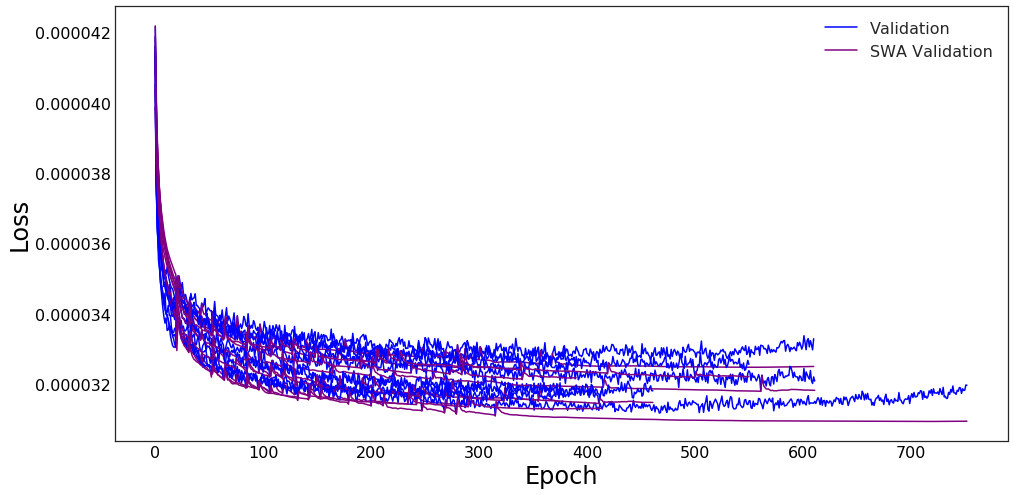

Mean loss = 3.18e-05 +- 2e-07
Mean wAUC = 0.0635 +- 0.0007
Mean AUC = 0.0992 +- 0.0008
______________________________________



<Figure size 432x288 with 0 Axes>

In [14]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          swaStart=1, swaRenewal=5, sgdReplacement=True,
                                          patience=50, cosAnnealMult=1, reduxDecay=False, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"